In [ ]:
!pip install demoji neologdn mecab-python3

from google.colab import drive
drive.mount('/content/drive/')

import os
os.environ["MECABRC"] = '/content/drive/MyDrive/mecab/etc/mecabrc'




Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.5/581.5 kB 50.7 MB/s eta 0:00:00
  Created wheel for neologdn: filename=neologdn-0.5.1-cp39-cp39-linux_x86_64.whl size=205505 sha256=4f4e5cef3fcf17cbe55a141eef44e95250997cdcfccc482a334f253f756e181e
  Stored in directory: /root/.cache/pip/wheels/b9/86/e7/4aee13f3da56da7dfc8327074406a701a2d99eaa842f805eaf
Successfully built neologdn
Mounted at /content/drive/


In [ ]:
import MeCab
from sklearn.base import BaseEstimator,TransformerMixin
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion,make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from collections import Counter,defaultdict
import re
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import numpy as np
from sklearn.pipeline import Pipeline
import demoji
import pandas as pd
import neologdn
from scipy import sparse
import json
from sklearn.model_selection import train_test_split
import  tqdm

class PreprocessConverter(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass

    def fit(self,X,y=None):
      return self

    @classmethod
    def preprocess(cls,text):
        text = re.sub(r'\n', ' ', text)
        text = re.sub(r'http?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text)
        text = re.sub(r'https?://[\w/:%#\$&\?\(\)~\.=\+\-]+', '', text)
        text = re.sub(r'^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$',"",text)

        text = demoji.replace(string=text, repl='')
        text = text.lower()
        text = neologdn.normalize(text, tilde='normalize')
        return text

    def transform(self,X,y=None):
        if type(X) == list:
            return list(map(self.preprocess,X))
        if type(X) == pd.Series:
            return X.apply(self.preprocess)

    def fit_transform(self,X,y=None):
        return self.transform(X)



class OwakatiTokenizer(BaseEstimator,TransformerMixin):
    def __init__(self, dicdir=None, rcfile=None,subject_body_split=True, **kwgs):
        """
        :param dicdir: system dicdir `-d`
        :param rcfile: resource file `-r`
        """
        self.dicdir = dicdir
        self.rcfile = rcfile
        self.subject_body_split = subject_body_split
        self.args = self.get_arguments()
        self.tagger = MeCab.Tagger(self.args)

    def wakati_text(self,text,select_conditions=['名詞','動詞']):
        # 分けてノードごとにする
        node = self.tagger.parseToNode(str(text))
        terms = []

        while node:

            # 単語
            term = node.surface

            # 品詞
            pos = node.feature.split(',')

            # もし品詞が条件と一致してたら
            if pos[0] in select_conditions:
                if not (pos[0] == '名詞' and pos[1] == '固有名詞'): 
                    terms.append(term)


            node = node.next

        text_result = ' '.join(terms)
        return text_result

    def get_arguments(self):
        args = ["-Owakati"]
        if self.dicdir:
            args.append(f"-d {self.dicdir}")
        if self.rcfile:
            args.append(f"-r {self.rcfile}")
        return " ".join(args)

    def fit(self, X, y=None):
        return self

    def transform(self, X,y=None):
        if type(X) == list:
            return list(map(self.wakati_text,X))
        if type(X) == pd.Series:
            return X.apply(self.wakati_text)
        
        

    def fit_transform(self, X, y=None):
        return self.transform(X)


    def __reduce_ex__(self, proto):
        return type(self), (
            self.dicdir,
            self.rcfile,
        )

feature_pipeline = make_pipeline(
                                                PreprocessConverter(),
                                                OwakatiTokenizer(dicdir="/content/drive/MyDrive/mecab/mecab-ipadic-neologd"),
                                                CountVectorizer(),
                                                TruncatedSVD(300),
                                      )

In [ ]:
import os
import pandas as pd

df_matter =  pd.DataFrame(json.load(open("****","r"))["data"])
df_person =  pd.DataFrame(json.load(open("****","r"))["data"])
df = pd.concat([df_matter,df_person],)
feature_pipeline.fit(df['body'])

Pipeline(steps=[('preprocessconverter', PreprocessConverter()),
                ('owakatitokenizer',
                 OwakatiTokenizer(dicdir='/content/drive/MyDrive/mecab/mecab-ipadic-neologd')),
                ('countvectorizer', CountVectorizer()),
                ('truncatedsvd', TruncatedSVD(n_components=300))])

In [ ]:
from skimage.util.shape import view_as_windows as viewW
from scipy import signal
from scipy import fftpack
from itertools import zip_longest
def strided_indexing_roll(a, r):
    a_ext = np.concatenate((a,a[:,:-1]),axis=1)
    n = a.shape[1]
    return viewW(a_ext,(1,n))[np.arange(len(r)), (n-r)%n,0]

def find_peaks(x, threshold,distance):
    above_thre = x > threshold
    above_thre_smooth = np.convolve(above_thre, [True]*5,mode="same")
    indices = np.argwhere((above_thre_smooth)^ (np.concatenate([[False], above_thre_smooth[:-1]]))).flatten()[::2]
    indices = list(zip_longest(indices,indices[1:],fillvalue=len(x)))
    return list(filter(lambda x:x[1]-x[0] >= distance,indices))
def cossim(mx,smooth=True):
    norm = (mx * mx).sum(0, keepdims=True) ** .5 + 1e-16
    sim_mat = mx.T @ mx / norm / norm.T
    if not smooth:
        return sim_mat
    rolled = strided_indexing_roll(sim_mat,-np.arange(len(sim_mat)))
    averaged = np.apply_along_axis(np.convolve, 0, rolled, np.ones(5)/5, mode="same")
    return strided_indexing_roll(averaged,np.arange(len(sim_mat)))
def multiple_indices(mt):
    ssm = cossim(mt.T**2)
    ssm[np.diag_indices(len(ssm))] = 0
    ssm_max = np.max(ssm,axis=0)
    #argwhere でとってきた最初のindexで、find_peaks(ssm[:,index])とするほうがいい？
    indices =find_peaks(ssm_max,threshold=0.8,distance=3)
    return indices

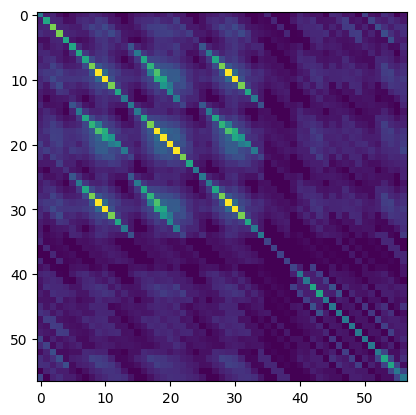

CPU times: user 288 ms, sys: 38 ms, total: 326 ms
Wall time: 386 ms


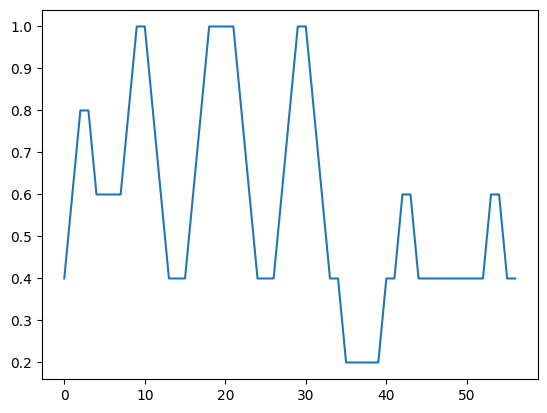

In [ ]:
%%time 
d = df_multi[df_multi['id']=='852']['body']

mt = d.apply(lambda x:x.split('\n')).apply(feature_pipeline[:2].transform).apply(lambda x:list(map(lambda y:y.split(" ")[0],x))).apply(feature_pipeline[2:].transform).apply(np.array).values[0]
ssm= cossim(mt.T **2)
plt.imshow(ssm)
plt.show()
plt.plot(range(len(ssm)),np.max(ssm,axis=0))